# Signal Processing Project: real-time sound localisation

## 1 Offline system
### 1.1 Data generation and dataset

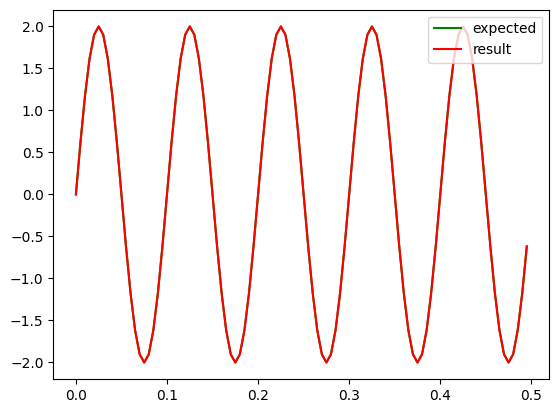

In [37]:
import numpy as np
import matplotlib.pyplot as plt


def create_sine_wave(f, A, fs, N):
    # create values for the x axis : [0, 1, 2, ... , N-3, N-2, N-1]
    x_data = np.arange(0, N, 1) / fs
    # create values for the y axis : sin(2 * pi * f) * A
    y_data = np.sin(2 * np.pi * f * x_data) * A
    return y_data


# call and test your function here
fs = 200
N = 100
freq = 10
amplitude = 2

x_data = np.arange(0, N, 1) / fs
sin_wave = create_sine_wave(freq, amplitude, fs, N)
plt.plot(x_data, np.sin(2 * np.pi * freq * x_data) * amplitude, color='green', label='expected')
plt.plot(x_data, sin_wave, color='red', label='result')
plt.legend(loc='upper right')
plt.show()


In [38]:
from glob import glob
import scipy.io.wavfile as wf
from os import getcwd
from sys import platform


def read_wavefile(path):
    user_os = platform.lower().strip()
    separator = '\\' if user_os.startswith("win") else '/'
    LocateClaps = f"{getcwd()}{separator}LocateClaps"
    return wf.read(f"{LocateClaps}/{path}{'.wav' if not path.endswith('.wav') else ''}")


# call and test your function here #
user_os = platform.lower().strip()
separator = '\\' if user_os.startswith("win") else '/'
LocateClaps = f"{getcwd()}{separator}LocateClaps"
files = glob(f"{LocateClaps}/*.wav")
print(files)

read_wavefile("M1_30")


['/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_0.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_120.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_150.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_180.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_210.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_240.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_270.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_30.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_300.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_330.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_60.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M1_90.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M2_0.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M2_120.wav', '/home/Nephty/Python/Projects/ClapLocator/LocateClaps/M2_150.wav', '

(44100, array([-28,  12,  56, ..., -40, -14,   3], dtype=int16))

### 1.2 Buffering

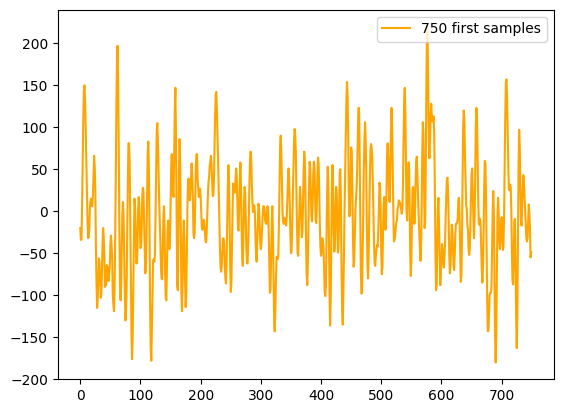

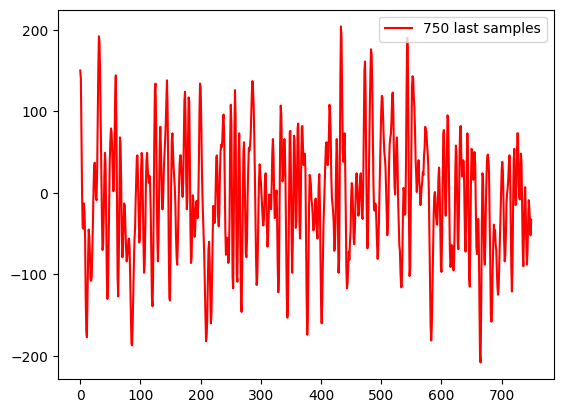

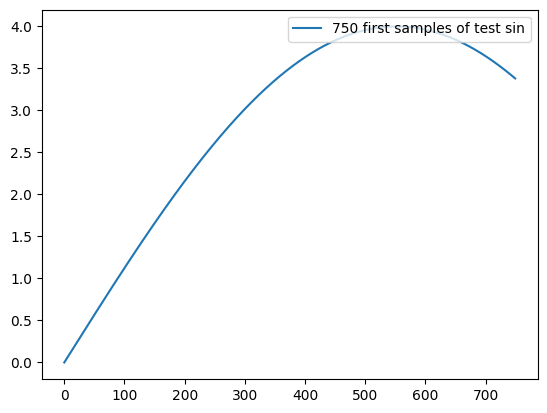

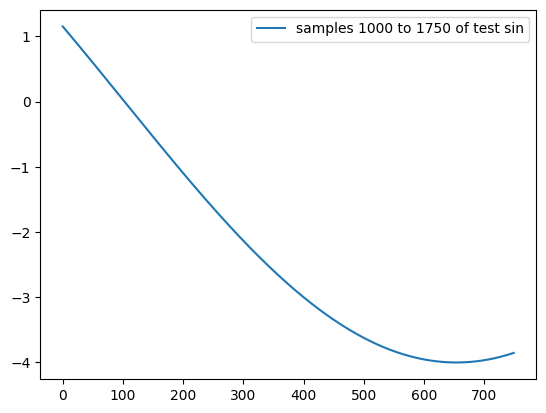

In [39]:
from collections import deque


def create_ringbuffer(maxlen):
    return deque(maxlen=maxlen)


# call and test your function here #
stride = 1  # step when iterating over buffer, how much we move the window forward
maxlen = 750
buffer = create_ringbuffer(maxlen)

for i, value in enumerate(create_sine_wave(20, 4, 44100, 8000)):
    buffer.append(value)
    # plot 750 first samples
    if i == 749:
        plt.plot(buffer, label="750 first samples of test sin")
        plt.legend(loc='upper right')
        plt.show()
    # plot samples from 1000 to 1750
    if i == 1749:
        plt.plot(buffer, label="samples 1000 to 1750 of test sin")
        plt.legend(loc='upper right')
        plt.show()

### 1.3 Pre-processing
#### 1.3.1 Normalisation

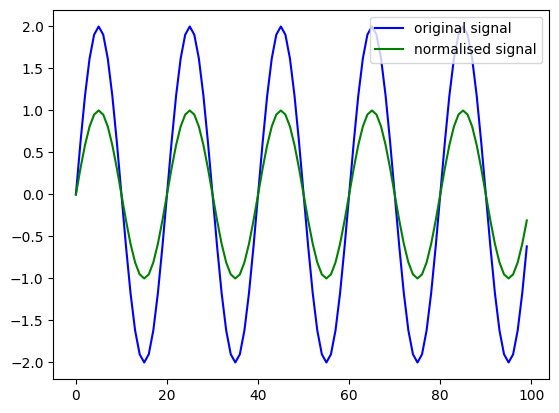

In [40]:
from copy import deepcopy


def normalise(s):
    return s / np.max(np.abs(s))


# call and test your function here #
plt.plot(sin_wave, color="blue", label="original signal")
plt.plot(normalise(sin_wave), color="green", label="normalised signal")
plt.legend(loc='upper right')
plt.show()

#### 1.3.2 Downsampling

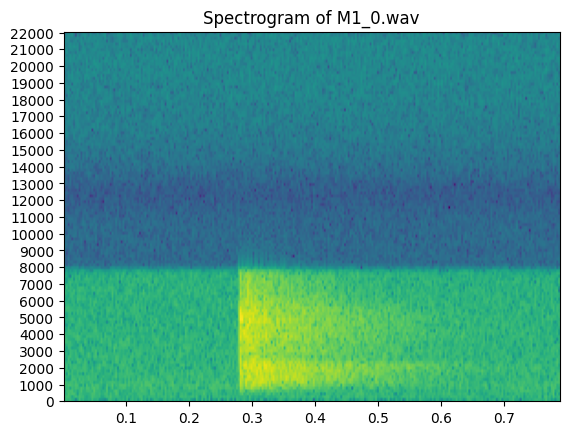

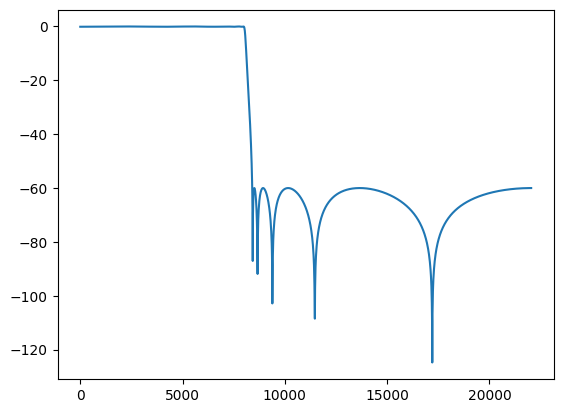

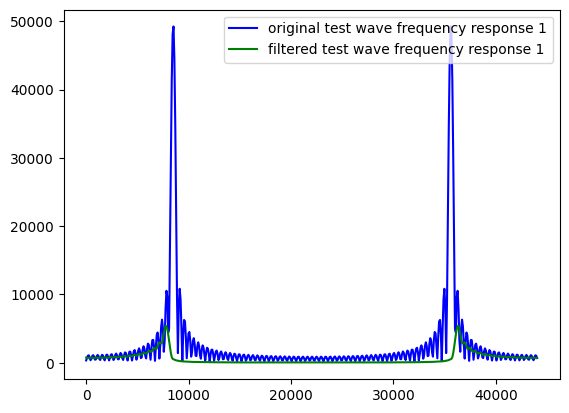

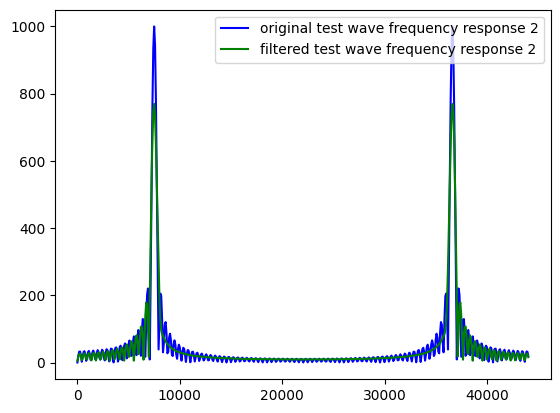

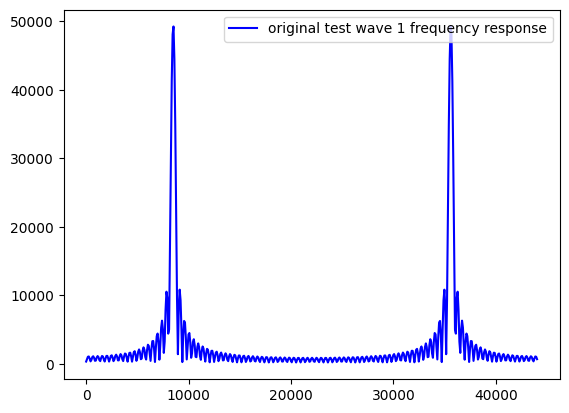

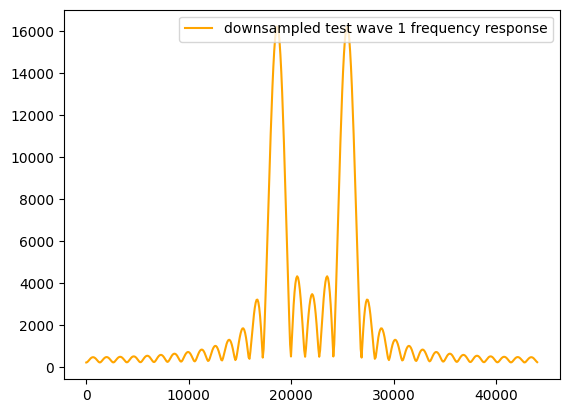

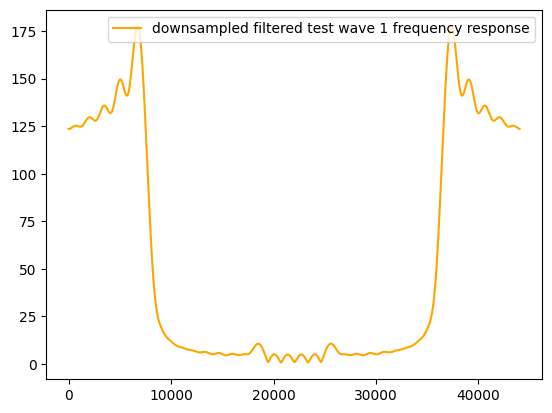

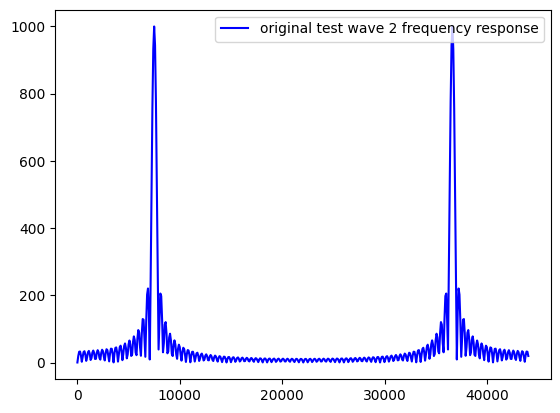

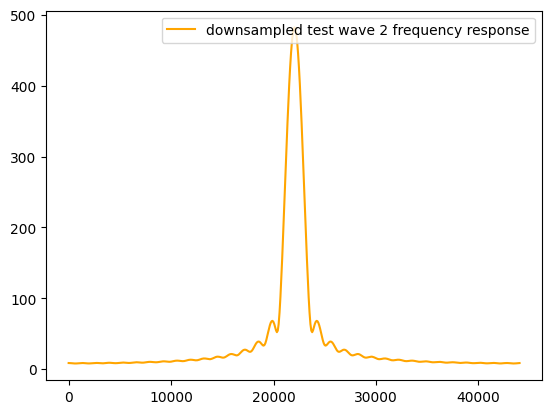

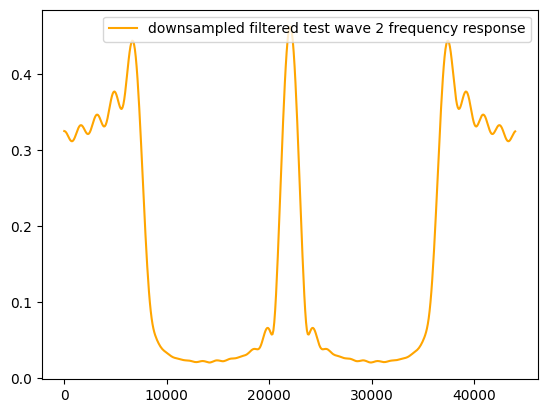

In [47]:
import scipy.signal as signal

## 1 - spectral analysis via spectrogram
fs = 44100
yticks = np.arange(0, 22500, 1000)

chosen_file_index = 0
file_read = read_wavefile("M1_30")[1]
plt.yticks(yticks)
plt.specgram(file_read, Fs=fs)
plt.title(f"Spectrogram of {files[chosen_file_index].split(separator)[-1]}")
plt.show()

## 2 - Anti-aliasing filter synthesis
def create_filter_cheby(wp, ws, gpass, gstop, fs):
    n, wn = signal.cheb1ord(wp / (fs / 2), ws / (fs / 2), gpass, gstop, fs=fs)
    B, A = signal.cheby1(N=n, rp=gpass, Wn=wn, btype='bandstop', fs=fs, output='ba')
    return B, A


def create_filter_cauer(wp, ws, gpass, gstop, fs):
    #n, wn = signal.ellipord(wp, ws, gpass, gstop, fs=fs)
    B, A = signal.ellip(10, gpass, gstop, ws, btype="lowpass", output="ba", fs=fs)
    return B, A


## 3 - Decimation
def downsampling(sig, M):
    return deepcopy(sig)[::M]


# cheby_b, cheby_a = create_filter_cheby(np.array([1, 2000]), np.array([1, 44100]), 0.5, 50, fs=16000) # changer 8000 et 8200
cauer_b, cauer_a = create_filter_cauer(1, 8000, 0.1, 60, 44100)

# Frequency response of cauer filter
w, h = signal.freqz(cauer_b, cauer_a, 2048, fs=44100)
h = 20 * np.log10(abs(h))
plt.plot(w, h)
plt.show()

test_sin_wave_1 = create_sine_wave(8500, 1000, 44100, 100)
b, a = test_sin_wave_1, 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="blue", label="original test wave frequency response 1")

b, a = signal.lfilter(cauer_b, cauer_a, test_sin_wave_1), 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="green", label="filtered test wave frequency response 1")
plt.legend(loc="upper right")
plt.show()

test_sin_wave_2 = create_sine_wave(7500, 20, 44100, 100)
b, a = test_sin_wave_2, 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="blue", label="original test wave frequency response 2")

b, a = signal.lfilter(cauer_b, cauer_a, test_sin_wave_2), 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="green", label="filtered test wave frequency response 2")
plt.legend(loc="upper right")
plt.show()

b, a = test_sin_wave_1, 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="blue", label="original test wave 1 frequency response")
plt.legend(loc="upper right")
plt.show()
b, a = downsampling(test_sin_wave_1, 3), 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="orange", label="downsampled test wave 1 frequency response")
plt.legend(loc="upper right")
plt.show()
b, a = signal.lfilter(cauer_b, cauer_a, downsampling(test_sin_wave_1, 3)), 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="orange", label="downsampled filtered test wave 1 frequency response")
plt.legend(loc="upper right")
plt.show()

b, a = test_sin_wave_2, 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="blue", label="original test wave 2 frequency response")
plt.legend(loc="upper right")
plt.show()
b, a = downsampling(test_sin_wave_2, 3), 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="orange", label="downsampled test wave 2 frequency response")
plt.legend(loc="upper right")
plt.show()
b, a = signal.lfilter(cauer_b, cauer_a, downsampling(test_sin_wave_2, 3)), 1
w, h = signal.freqz(b, a, whole=True, fs=44100)
plt.plot(w, abs(h), color="orange", label="downsampled filtered test wave 2 frequency response")
plt.legend(loc="upper right")
plt.show()

### 1.4 Cross-correlation

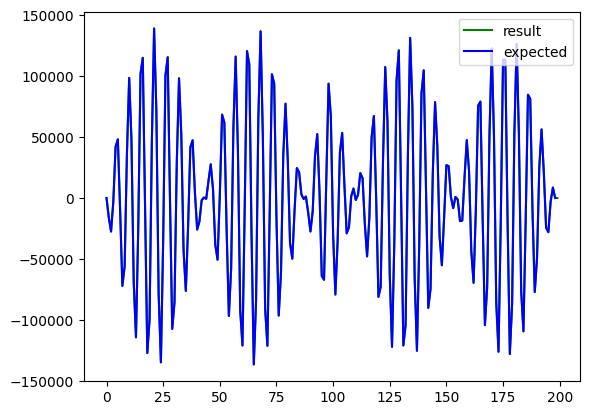

In [42]:
## 1.4
import scipy.signal as signal
import numpy as np
import random


def fftxcorr(in1, in2):
    n = 2 * len(in1)
    return np.fft.ifft(np.fft.fft(in1, n) * np.fft.fft(in2[::-1], n=2 * len(in2))).real


test_sin_wave_1 = create_sine_wave(8500, 1000, 44100, 100)
test_sin_wave_2 = create_sine_wave(7500, 20, 44100, 100)

xcorr_fftconv = signal.fftconvolve(test_sin_wave_1, test_sin_wave_2[::-1],
                                   'full')  # [::-1] flips the signal but you can also use np.flip()
plt.plot(xcorr_fftconv, color="blue", label="expected")

plt.plot(fftxcorr(test_sin_wave_1, test_sin_wave_2), color="green", label="result")
plt.legend(loc="upper right")
plt.show()

### 1.5 Localisation
#### 1.5.1 TDOA

In [43]:
def TDOA(xcorr):
    return np.argmax(xcorr) - (len(xcorr) / 2)  # / 44100


test_sin_wave_1 = create_sine_wave(8500, 1000, 44100, 100)
test_sin_wave_2 = create_sine_wave(7500, 20, 44100, 100)

xcorr_fftconv = fftxcorr(test_sin_wave_1, test_sin_wave_2)

print(TDOA(xcorr_fftconv))

-79.0


#### 1.5.2 Equation system

In [44]:
from scipy.optimize import root

# mic coordinates in meters
MICS = [{'x': 0, 'y': 0.0487}, {'x': 0.0425, 'y': -0.025}, {'x': -0.0425, 'y': -0.025}]


def equations(p, deltas):
    v = 343
    x, y = p
    eq1 = v * deltas[0] - np.sqrt((MICS[0]['x'] - x) ** 2 + (MICS[0]['y'] - y) ** 2) + np.sqrt(
        (MICS[1]['x'] - x) ** 2 + (MICS[1]['y'] - y) ** 2)
    eq2 = v * deltas[1] - np.sqrt((MICS[0]['x'] - x) ** 2 + (MICS[0]['y'] - y) ** 2) + np.sqrt(
        (MICS[2]['x'] - x) ** 2 + (MICS[2]['y'] - y) ** 2)
    return (eq1, eq2)


def localize_sound(deltas):
    sol = root(equations, [0, 0], (deltas), tol=10)
    return sol.x


def source_angle(coordinates):
    x = coordinates[0]  # x of the source
    y = coordinates[1]  # y of the source

    angle = np.arctan(y / x) * 180 / np.pi

    if angle < 0:
        angle += 180
        if y <= 0:
            angle += 180
    elif angle > 0:
        if y < 0:
            angle += 180
    return angle

fs, M1_60 = read_wavefile("M1_120")
M2_60 = read_wavefile("M2_120")[1]
M3_60 = read_wavefile("M3_120")[1]

xcorr1_2 = fftxcorr(M1_60, M2_60)
xcorr1_3 = fftxcorr(M1_60, M3_60)

tdoa2_1 = TDOA(xcorr1_2) / fs
tdoa3_1 = TDOA(xcorr1_3) / fs

sound = localize_sound([tdoa2_1, tdoa3_1])

print(sound)
print(source_angle(sound))

[-0.02255908  0.04346551]
117.42981394298297


### 1.6 System accuracy and speed

In [62]:
## 1.6.1
def accuracy(pred_angle, gt_angle, threshold):
    return abs(pred_angle - gt_angle) <= threshold


## 1.6.2
possible_angle = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
print("\nWithout downsampling")
errors = []
for angle in possible_angle:
    fs, M1 = read_wavefile(f"M1_{angle}")
    M1 = M1
    M2 = read_wavefile(f"M2_{angle}")[1]
    M3 = read_wavefile(f"M3_{angle}")[1]

    xcorr1_2 = fftxcorr(M1, M2)
    xcorr1_3 = fftxcorr(M1, M3)
    tdoa2_1 = TDOA(xcorr1_2) / fs
    tdoa3_1 = TDOA(xcorr1_3) / fs

    sound = localize_sound([tdoa2_1, tdoa3_1])

    estimated_angle = source_angle(sound)
    errors.append(abs(angle - estimated_angle))

    print(f"Expected angle : {angle}, got {estimated_angle}. Accurate : {accuracy(estimated_angle, angle, 15)}.")

print(f"\nAverage error : {sum(errors) / len(errors)}°.")

print("\nWith downsampling")

errors = []
for angle in possible_angle:
    fs, M1 = read_wavefile(f"M1_{angle}")
    M1 = downsampling(M1, 3)
    M2 = downsampling(read_wavefile(f"M2_{angle}")[1], 3)
    M3 = downsampling(read_wavefile(f"M3_{angle}")[1], 3)

    xcorr1_2 = fftxcorr(M1, M2)
    xcorr1_3 = fftxcorr(M1, M3)
    tdoa2_1 = TDOA(xcorr1_2) / fs
    tdoa3_1 = TDOA(xcorr1_3) / fs

    sound = localize_sound([tdoa2_1, tdoa3_1])

    estimated_angle = source_angle(sound)
    errors.append(abs(angle - estimated_angle))

    print(f"Expected angle : {angle}, got {estimated_angle}. Accurate : {accuracy(estimated_angle, angle, 15)}.")

print(f"\nAverage error : {sum(errors) / len(errors)}°.\n\n")

## 1.6.3
from time import time_ns, sleep


def func_example(a, b):
    return a * b


def time_delay(func, args):
    start_time = time_ns()
    out = func(*args)
    end_time = time_ns()
    ns = end_time - start_time
    print(f"{func.__name__} in {ns} ns = {ns / 1000} µs = {ns / 1000000} ms")
    return out


product = time_delay(func_example, [2, 10])

# call and test your previous functions here #
sig = read_wavefile("M1_30")[1]
sig2 = read_wavefile("M2_30")[1]
sig3 = read_wavefile("M3_30")[1]

print("Without downsampling")
time_delay(normalise, [sig])
time_delay(downsampling, [sig, 3])
time_delay(fftxcorr, [sig, sig2])

xcorr1_2 = fftxcorr(sig, sig2)
xcorr1_3 = fftxcorr(sig, sig3)
tdoa2_1 = TDOA(xcorr1_2) / fs
tdoa3_1 = TDOA(xcorr1_3) / fs

time_delay(TDOA, [xcorr1_2])

time_delay(localize_sound, [[tdoa2_1, tdoa3_1]])

coordinates = localize_sound([tdoa2_1, tdoa3_1])

time_delay(source_angle, [coordinates])

cauer_b, cauer_a = create_filter_cauer(1, 8000, 0.1, 60, 44100)
sig = downsampling(normalise(read_wavefile("M1_30")[1]), 3)
sig2 = downsampling(normalise(read_wavefile("M2_30")[1]), 3)
sig3 = downsampling(normalise(read_wavefile("M3_30")[1]), 3)

print("\nWith downsampling")
time_delay(fftxcorr, [sig, sig2])

xcorr1_2 = fftxcorr(sig, sig2)
xcorr1_3 = fftxcorr(sig, sig3)
tdoa2_1 = TDOA(xcorr1_2) / fs
tdoa3_1 = TDOA(xcorr1_3) / fs

time_delay(TDOA, [xcorr1_2])

time_delay(localize_sound, [[tdoa2_1, tdoa3_1]])

coordinates = localize_sound([tdoa2_1, tdoa3_1])

time_delay(source_angle, [coordinates])

Expected angle : 0, got 14.768800014046723. Accurate : True.
Expected angle : 30, got 42.72096706486629. Accurate : True.
Expected angle : 60, got 75.66878558877559. Accurate : False.
Expected angle : 90, got 90.0. Accurate : True.
Expected angle : 120, got 104.33121494056877. Accurate : False.
Expected angle : 150, got 137.27903762320807. Accurate : True.
Expected angle : 180, got 165.23120808830063. Accurate : True.
Expected angle : 210, got 192.43151479974452. Accurate : False.
Expected angle : 240, got 241.01570777980936. Accurate : True.
Expected angle : 270, got 270.0. Accurate : True.
Expected angle : 300, got 298.9842942661145. Accurate : True.
Expected angle : 330, got 347.5684934628657. Accurate : False.

Average error : 10.290457016035601°.
func_example in 972 ns = 0.972 µs = 0.000972 ms
Without downsampling
normalise in 114244 ns = 114.244 µs = 0.114244 ms
downsampling in 14597 ns = 14.597 µs = 0.014597 ms
fftxcorr in 50260733 ns = 50260.733 µs = 50.260733 ms
TDOA in 155430

42.72096706486629